In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import pymc3 as pm
import scipy as sp
import pyccl as ccl
import os
import utils
import make_data
import getdist
from getdist import plots, MCSamples
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
names_planck  = ['H', 'Omega_m', 'sigma8']
labels_planck = ['H', r'\Omega_{\rm{m}}', r'\sigma_{\rm{8}}']

planck1 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_1.txt')
planck2 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_2.txt')
planck3 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_3.txt')
planck4 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_4.txt')

planck_tot = np.concatenate((planck1, planck2, planck3, planck4), axis=0)

planck_params = []
for item in planck_tot:
    planck_params.append([item[29], item[31], item[34]])
planck_params = np.array(planck_params)
planck= MCSamples(samples=planck_params, names = names_planck, labels = labels_planck, label= r'$Planck$ 2018',
                    weights=np.transpose(planck_tot)[0],loglikes=np.transpose(planck_tot)[1])

Removed no burn in


In [3]:
z_max = 2.5
path = '/home/jaimerz/PhD/Growz/data/outputs/'
data = make_data.make_data(z_max, 2, path)
DESI = data.get_DESI(new=True)
WFIRST = data.get_WFIRST(new=True)
CC = data.get_CC(new=True)
DSS = data.get_DSS(new=True)
BOSS = data.get_BOSS(new=True)
eBOSS = data.get_eBOSS(new=True)
Wigglez = data.get_Wigglez(new=True)
DS17 = data.get_DS17(new=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jaimerz/PhD/Growz/data/outputs/DESI.npz'

In [ ]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [ ]:
path = '/home/jaimerz/PhD/Growz/data/outputs/'
Panth = np.load(os.path.join(path,'Panth_1000_1000/samples.npz'))
All_Data = np.load(os.path.join(path,'CC_DS17_BOSS_eBOSS_Wigglez_DSS_2500_2500/samples.npz'))
CC_DS17 = np.load(os.path.join(path,'CC_DS17_10000_10000/samples.npz'))
BOSS_eBOSS = np.load(os.path.join(path,'BOSS_eBOSS_2500_2500/samples.npz'))
WFIRST = np.load(os.path.join(path,'WFIRST_2500_2500/samples.npz'))
DESI = np.load(os.path.join(path,'DESI_2500_2500/samples.npz'))

In [ ]:
matern52 = np.load(os.path.join(path,'matern52_2000_2000/samples.npz'))
RatQuad = np.load(os.path.join(path,'RatQuad_2000_2000/samples.npz'))
ExpQuad = np.load(os.path.join(path,'ExpQuad_2000_2000/samples.npz'))
DESIfs8_Planck = np.load(os.path.join(path,'DESIfs8_Planck_1000_1000/samples.npz'))
DESIfs8_Planck_fit = np.load(os.path.join(path,'DESIfs8_Planck_fit_1500_1500/samples.npz'))
DESIfs8_Riess0 = np.load(os.path.join(path,'DESIfs8_Riess_fit0_1000_1000/samples.npz'))
DESIfs8_Riess1 = np.load(os.path.join(path,'DESIfs8_Riess_fit1_1000_1000/samples.npz'))
DESIfs8_Riess2 = np.load(os.path.join(path,'DESIfs8_Riess_fit2_1000_1000/samples.npz'))

In [63]:
labels_dict = {'n': '\eta',
               'l': 'l',
               'H0': 'H',
               'Omega_m': '\Omega_m',
               's80': '\sigma_8',
               'S80': 'S_8',
               'Omega_b': '\Omega_b', 
               'rd': 'r_d',
               'Df': '\Delta f', 
               'M': 'M'}
names_All = ['n', 'l', 'H', 'Omega_m', 's80', 'S80', 'Omega_b', 'Df', 'M']
ranges = {'l':[0.0, 100]}

In [66]:
def make_samples(file, names, ranges, label):
    samples = []
    for name in names:
        samples.append(file[name])
        
    labels = []
    for name in names:
        labels.append(labels_dict[name])
        
    return MCSamples(samples=samples, names=names, labels=labels, label=label, ranges=ranges)

In [67]:
WFIRST_samples = make_samples(WFIRST, ['n', 'l', 'H0'], ranges, 'WFIRST')
DESI_samples = make_samples(DESI, ['n', 'l', 'H0', 'Omega_m', 's80', 'S80', 'Df'], ranges, 'DESI')
BOSS_eBOSS_samples = make_samples(BOSS_eBOSS, ['n', 'l', 'H0', 'Omega_m', 'Omega_b', 's80', 'S80', 'rd', 'Df'], ranges, 'BOSSS+eBOSS')
CC_DS17_samples = make_samples(CC_DS17, ['n', 'l', 'H0', 'M'], ranges, 'CC+DS17')
All_Data_samples = make_samples(All_Data, ['n', 'l', 'H0', 'Omega_m', 'Omega_b', 's80', 'S80', 'rd', 'Df', 'M'], ranges, 'All Data')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


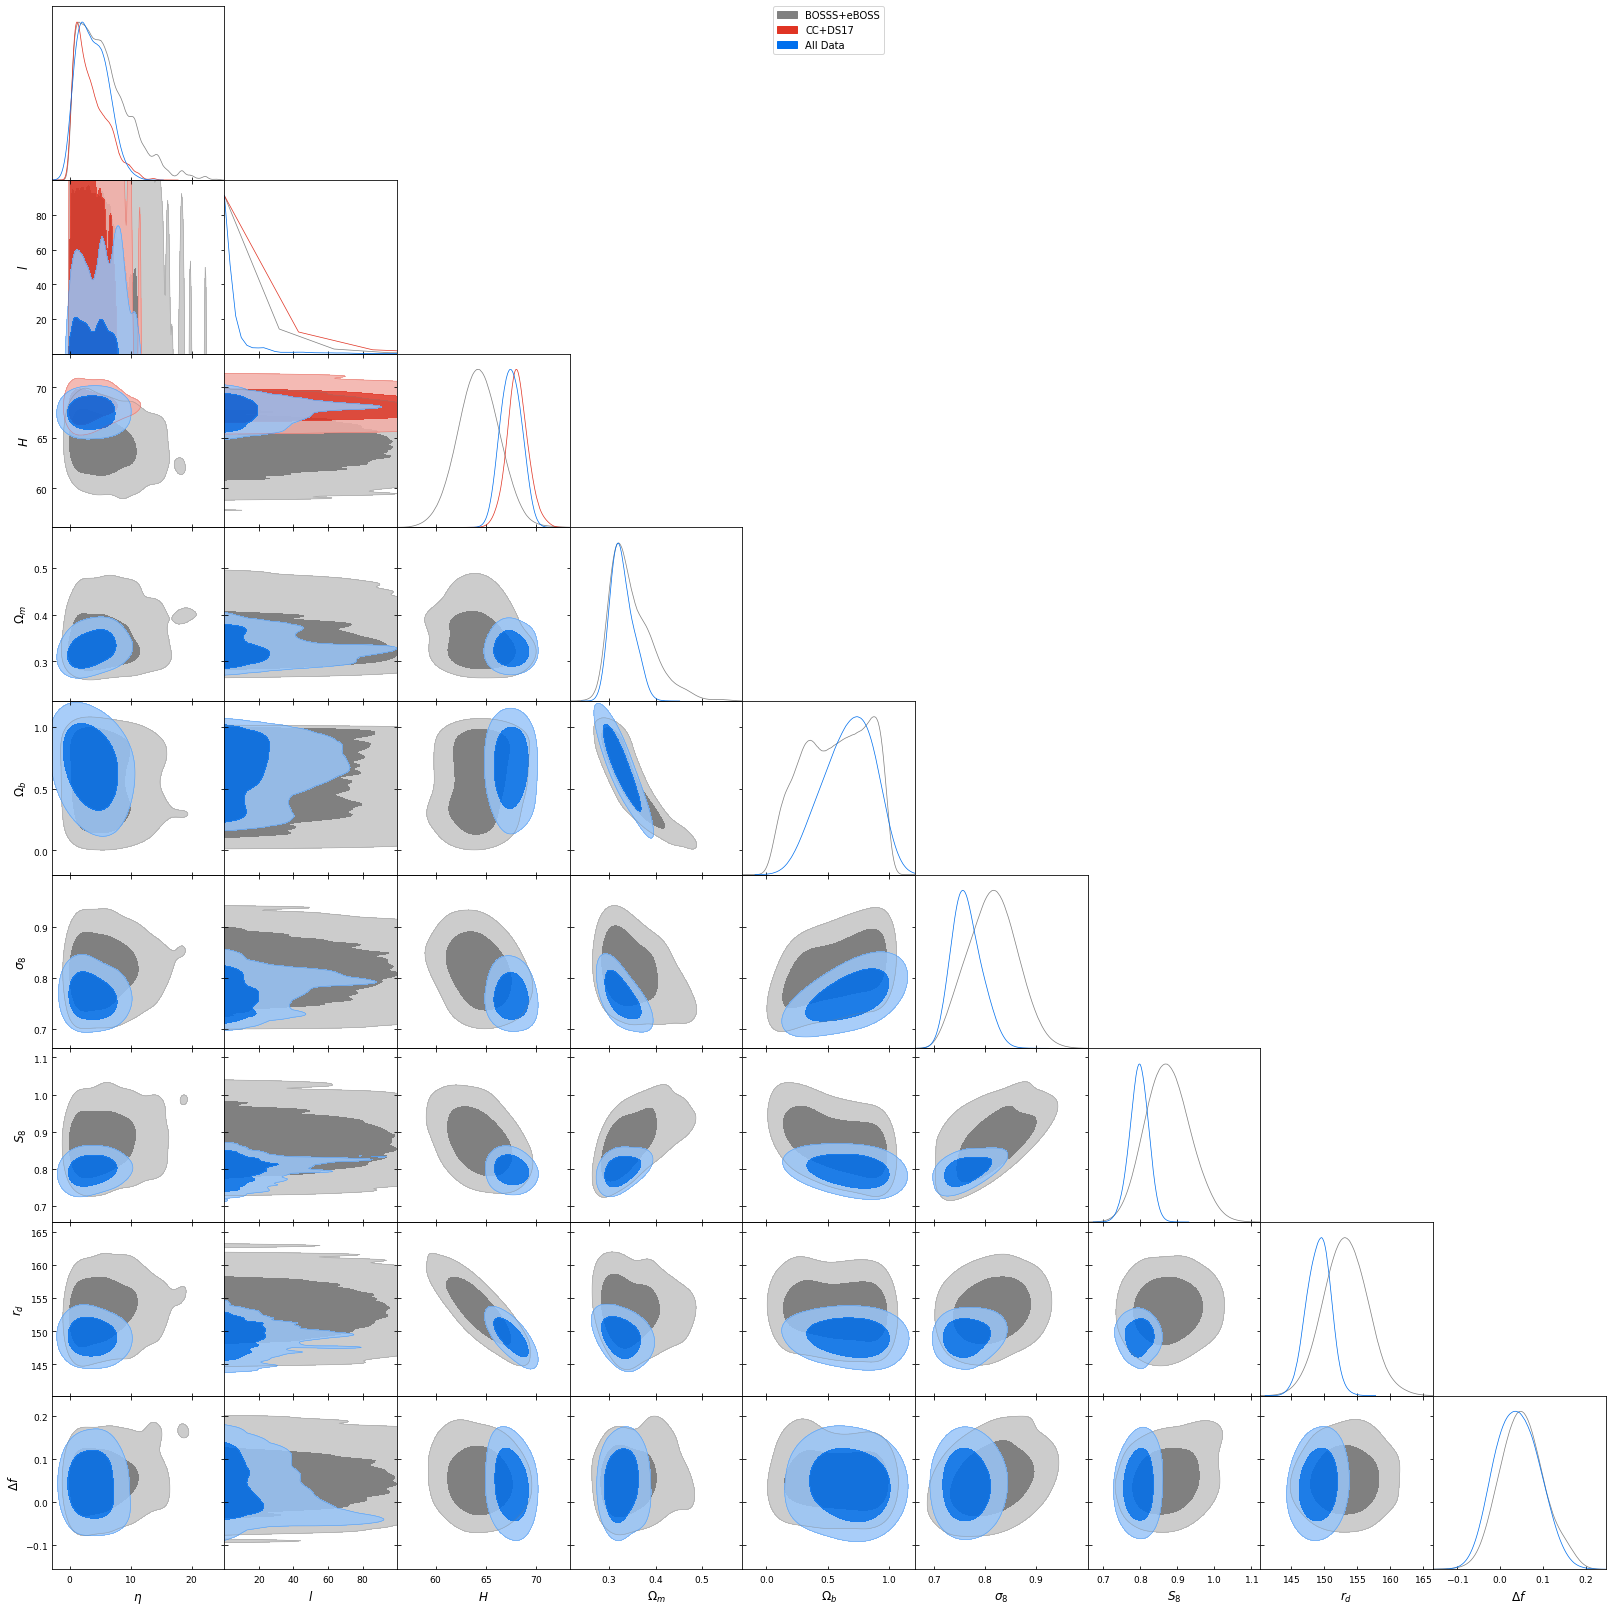

In [68]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([BOSS_eBOSS_samples, CC_DS17_samples, All_Data_samples],
                filled=True)
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

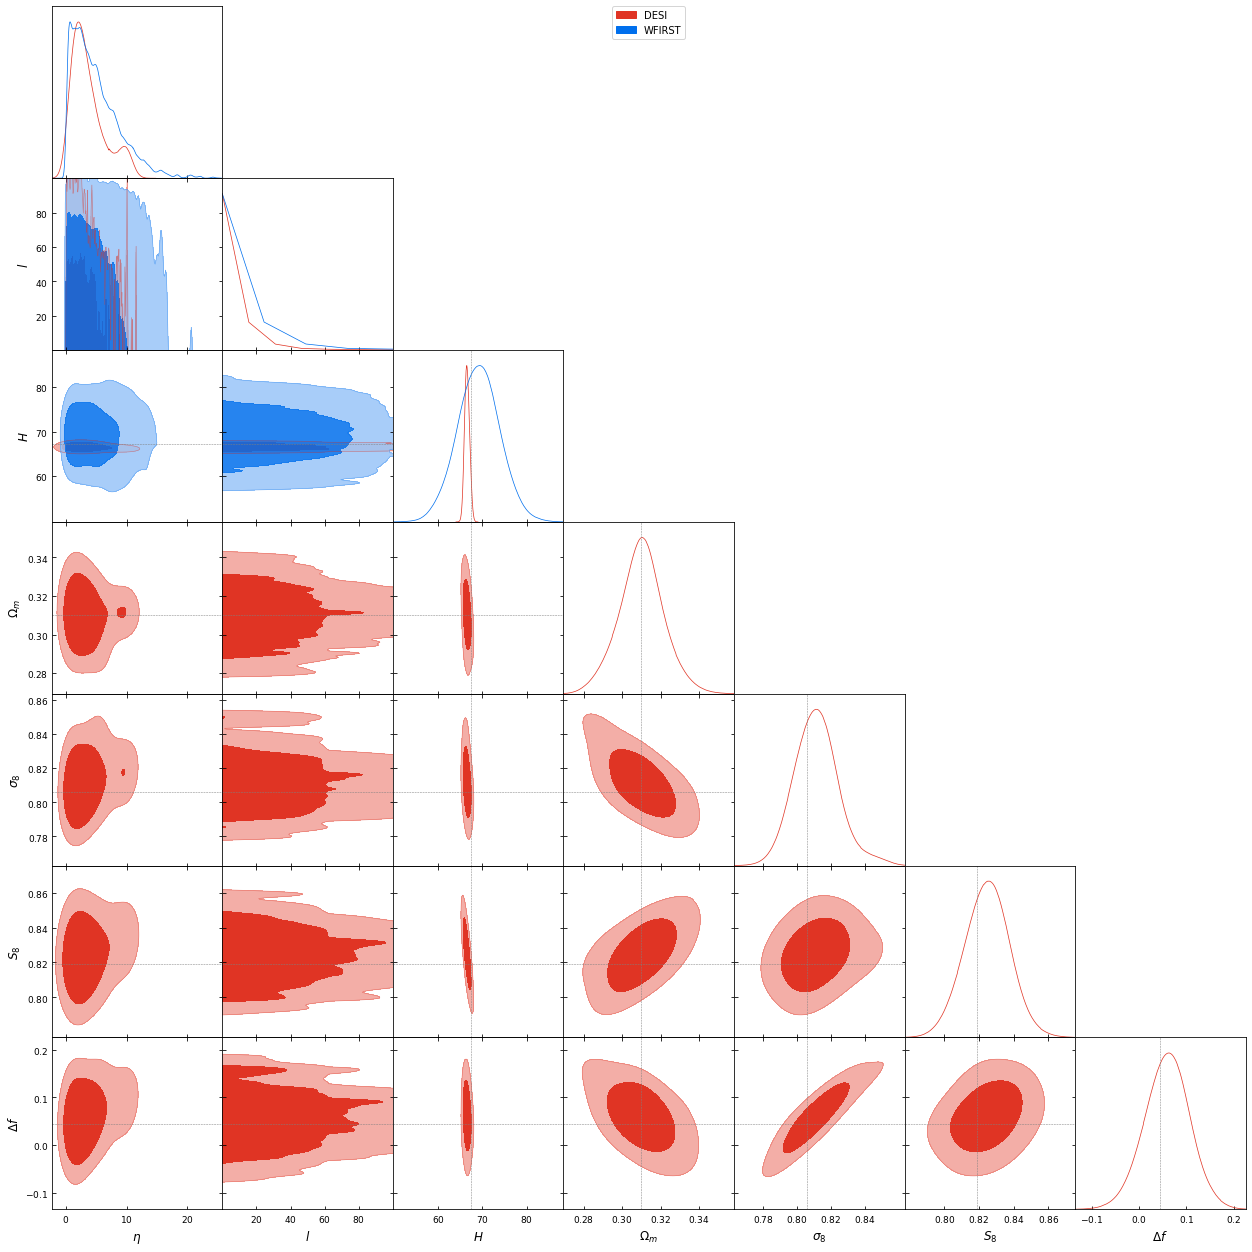

In [40]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_samples, WFIRST_samples], filled=True,
                markers={'H0':67.3, 'Omega_m':0.31, 's80': 0.806, 'S80': 0.819 ,'Df': 0.044})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_forecast.pdf')

In [13]:
tools = utils.utils()
c = tools.c

H_All_m, H_All_s = get_m_s(All_Data['Hz'])
H_CC_DS17_m, H_CC_DS17_s = get_m_s(CC_DS17['Hz'])
H_BOSS_eBOSS_m, H_BOSS_eBOSS_s = get_m_s(BOSS_eBOSS['Hz'])
H_DESI_m, H_DESI_s = get_m_s(DESI['Hz'])
H_WFIRST_m, H_WFIRST_s = get_m_s(WFIRST['Hz'])
#H_DESIfs8_Planck_m, H_DESIfs8_Planck_s = get_m_s(DESIfs8_Planck['Hz'])
#H_DESIfs8_Planck_fit_m, H_DESIfs8_Planck_fit_s = get_m_s(DESIfs8_Planck_fit['Hz'])
#H_DESIfs8_Riess0_m, H_DESIfs8_Riess0_s = get_m_s(DESIfs8_Riess0['Hz'])
#H_DESIfs8_Riess1_m, H_DESIfs8_Riess1_s = get_m_s(DESIfs8_Riess1['Hz'])
#H_DESIfs8_Riess2_m, H_DESIfs8_Riess2_s = get_m_s(DESIfs8_Riess2['Hz'])
#H_matern52_m, H_matern52_s = get_m_s(matern52['Hz'])
#H_RatQuad_m, H_RatQuad_s = get_m_s(RatQuad['Hz'])
#H_ExpQuad_m, H_ExpQuad_s = get_m_s(ExpQuad['Hz'])

Planck_preds = tools.get_preds(All_Data['z_arr'], mode = 'Planck')
Riess_preds = tools.get_preds(All_Data['z_arr'], mode = 'Riess')
Panth_preds = tools.get_preds(All_Data['z_arr'], mode = 'Panth')

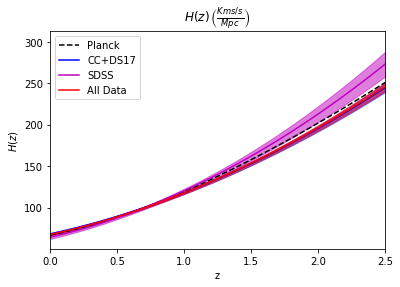

In [41]:
plt.plot(All_Data['z_arr'], Planck_preds['Hkms_arr'], 'k--', label='Planck')
#plt.plot(z_DESIfs8, Panth_preds['Hkms_arr'], 'k-.', label='Panth')

#plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='ko', label='CC')
#plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='kv', label='BOSS DR12')
#plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='ks', label='eBOSS DR16')

plt.plot(CC_DS17['z_arr'],  H_CC_DS17_m, color ='b', label='CC+DS17')
plt.fill_between(CC_DS17['z_arr'], H_CC_DS17_m+H_CC_DS17_s,
                 H_CC_DS17_m-H_CC_DS17_s, color='b', alpha=.5)
plt.plot(BOSS_eBOSS['z_arr'],  H_BOSS_eBOSS_m, color ='m', label='SDSS')
plt.fill_between(BOSS_eBOSS['z_arr'], H_BOSS_eBOSS_m+H_BOSS_eBOSS_s,
                 H_BOSS_eBOSS_m-H_BOSS_eBOSS_s, color='m', alpha=.5)
plt.plot(All_Data['z_arr'],  H_All_m, color ='r', label='All Data')
plt.fill_between(All_Data['z_arr'], H_All_m+H_All_s, H_All_m-H_All_s, color='r', alpha=.5)

# axis labels and title
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')  

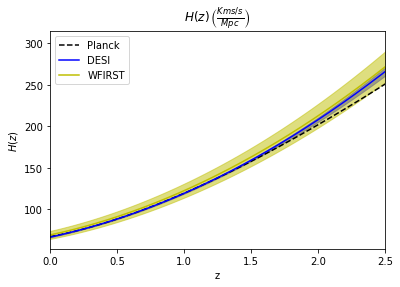

In [42]:
plt.plot(All_Data['z_arr'], Planck_preds['Hkms_arr'], 'k--', label='Planck')

plt.plot(DESI['z_arr'],  H_DESI_m, color ='b', label='DESI')
plt.fill_between(DESI['z_arr'], H_DESI_m+H_DESI_s, H_DESI_m-H_DESI_s, color='b', alpha=.5)

plt.plot(WFIRST['z_arr'],  H_WFIRST_m, color ='y', label='WFIRST')
plt.fill_between(WFIRST['z_arr'], H_WFIRST_m+H_WFIRST_s, H_WFIRST_m-H_WFIRST_s, color='y', alpha=.5)

# axis labels and title
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_forecast.pdf') 

In [43]:
dM_All_m, dM_All_s = get_m_s(All_Data['dMz'])
dM_CC_DS17_m, dM_CC_DS17_s = get_m_s(CC_DS17['dMz'])
dM_BOSS_eBOSS_m, dM_BOSS_eBOSS_s = get_m_s(BOSS_eBOSS['dMz'])
dM_DESI_m, dM_DESI_s = get_m_s(DESI['dMz'])

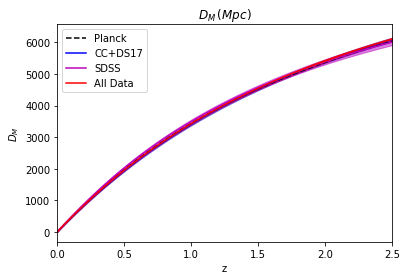

In [44]:
plt.plot(All_Data['z_arr'], Planck_preds['dM_arr'], 'k--', label='Planck')
#plt.plot(z_DESIfs8, Panth_preds['Hkms_arr'], 'k-.', label='Panth')

plt.plot(CC_DS17['z_arr'],  dM_CC_DS17_m, color ='b', label='CC+DS17')
plt.fill_between(CC_DS17['z_arr'], dM_CC_DS17_m+dM_CC_DS17_s,
                 dM_CC_DS17_m-dM_CC_DS17_s, color='b', alpha=.5)
plt.plot(BOSS_eBOSS['z_arr'],  dM_BOSS_eBOSS_m, color ='m', label='SDSS')
plt.fill_between(BOSS_eBOSS['z_arr'], dM_BOSS_eBOSS_m+dM_BOSS_eBOSS_s,
                 dM_BOSS_eBOSS_m-dM_BOSS_eBOSS_s, color='m', alpha=.5)
plt.plot(All_Data['z_arr'],  dM_All_m, color ='r', label='All Data')
plt.fill_between(All_Data['z_arr'], dM_All_m+dM_All_s, dM_All_m-dM_All_s, color='r', alpha=.5)

plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')  

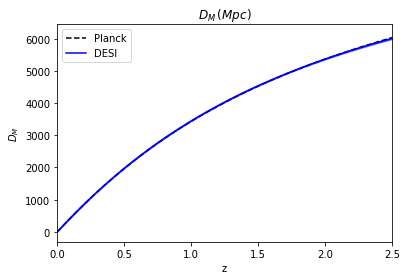

In [45]:
plt.plot(All_Data['z_arr'], Planck_preds['dM_arr'], 'k--', label='Planck')

plt.plot(DESI['z_arr'],  dM_DESI_m, color ='b', label='DESI')
plt.fill_between(DESI['z_arr'], dM_DESI_m+dM_DESI_s, dM_DESI_m-dM_DESI_s, color='b', alpha=.5)

plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_forecast.pdf') 

In [46]:
fs8_All_m, fs8_All_s = get_m_s(All_Data['fs8z'])
fs8_BOSS_eBOSS_m, fs8_BOSS_eBOSS_s = get_m_s(BOSS_eBOSS['fs8z'])
#fs8_BOSSfs8_m, fs8_BOSSfs8_s = get_m_s(BOSSfs8['fs8z'])
fs8_DESI_m, fs8_DESI_s = get_m_s(DESI['fs8z'])

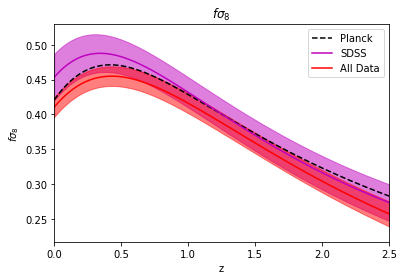

In [47]:
plt.plot(All_Data['z_arr'], Planck_preds['f_arr']*Planck_preds['s8_arr'], 'k--', label='Planck')

plt.plot(BOSS_eBOSS['z_arr'],  fs8_BOSS_eBOSS_m, color ='m', label='SDSS')
plt.fill_between(BOSS_eBOSS['z_arr'], fs8_BOSS_eBOSS_m+fs8_BOSS_eBOSS_s,
                 fs8_BOSS_eBOSS_m-fs8_BOSS_eBOSS_s, color='m', alpha=.5)
plt.plot(All_Data['z_arr'],  fs8_All_m, color ='r', label='All Data')
plt.fill_between(All_Data['z_arr'], fs8_All_m+fs8_All_s, fs8_All_m-fs8_All_s, color='r', alpha=.5)

plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')  

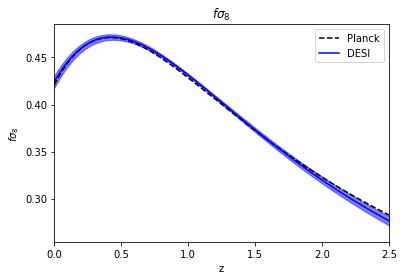

In [48]:
plt.plot(All_Data['z_arr'], Planck_preds['f_arr']*Planck_preds['s8_arr'], 'k--', label='Planck')

plt.plot(DESI['z_arr'],  fs8_DESI_m, color ='b', label='DESI')
plt.fill_between(DESI['z_arr'], fs8_DESI_m+fs8_DESI_s, fs8_DESI_m-fs8_DESI_s, color='b', alpha=.5)

plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_forecast.pdf')  